# CS 189 Project 1

## Alex McMurry

### Summary:
In this project for my machine learning class, I performed exploratory data analysis, cross-validation, and paramater tuning to optimize the accuracy of the SVM model on email and image-data. In so doing, I utilized Python libraries such as `Numpy`, `Scipy`, and `Scikit-Learn` to implement various classification models.

# 1) Python Configuration and Data Loading

In [1]:
import random as r
import sys
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from scipy import io

if sys.version_info[0] < 3:
 raise Exception("Python 3 not detected.")


for data_name in ["mnist", "spam", "cifar10"]:
    data = io.loadmat("data/%s_data.mat" % data_name)

    print("\nloaded %s data!" % data_name)
    fields = "test_data", "training_data", "training_labels"
    
    for field in fields:
        print(field, data[field].shape)


loaded mnist data!
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

loaded spam data!
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)

loaded cifar10 data!
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000, 1)


# 2) Data Partitioning

## (a) 
Set aside 10000 training images as a validation set. Shuffle the data's indices according to a given random seed and reassign the data accordingly. Then, split the data into training and validation sets.

In [2]:
# for MNISR, set aside 10,000 training images as a validation set
mnist_data = io.loadmat("data/mnist_data.mat")
mnist_train = mnist_data["training_data"]
mnist_label = mnist_data["training_labels"]
mnist_test = mnist_data["test_data"]

# Shuffle the indices and reassign the data to the now randomized indices
# This ensures the sample rows and label rows are in the same shuffled order
def split_mnist(train, label):
    mnist_idx = np.arange(60000)
    np.random.seed(10)
    np.random.shuffle(mnist_idx)
    
    return train[mnist_idx], label[mnist_idx]

mnist_train, mnist_label = split_mnist(mnist_train, mnist_label)

# Split the data into training and validation sets
mnist_validation_train, mnist_validation_label = mnist_train[:10000], mnist_label[:10000]
mnist_new_train, mnist_new_label = mnist_train[10000:], mnist_label[10000:]

## (b)
Set aside 20% of training data for the validation set. Randomly shuffle the data according to a given random seed, then split the Spam data into training and validation sets.

In [3]:
# for spam_data.mat, set aside 20% of the training data as a validation set
spam_data = io.loadmat("data/spam_data.mat")
spam_train = spam_data["training_data"]
spam_label = spam_data["training_labels"]
spam_test = spam_data["test_data"]
spam_validate = np.c_[spam_train, spam_label]

# Shuffle the indices and reassign the data to the now randomized indices
# This ensures the sample rows and label rows are in the same shuffled order
def split_spam(train, label):
    spam_idx = np.arange(len(spam_train))
    np.random.seed(10)
    np.random.shuffle(spam_idx)

    return train[spam_idx], label[spam_idx]


spam_train, spam_label = split_spam(spam_train, spam_label)

# Split the data into training and validation sets
pct = int(len(spam_train) * 20 / 100)
spam_validation_train, spam_validation_label = spam_train[:pct], spam_label[:pct]
spam_new_train, spam_new_label = spam_train[pct:], spam_label[pct:]

## (c)
Set aside 5000 training images of Cifar dataset as a validation set. Then, shuffle the data before splitting the data into training and validation sets.

In [4]:
# for CIFAR-10, set aside 5,000 training images as a validation set. Shuffle the data before splitting
cifar_data = io.loadmat("data/cifar10_data.mat")
cifar_train = cifar_data["training_data"]
cifar_label = cifar_data["training_labels"]
cifar_test = cifar_data["test_data"]
cifar_validate = np.c_[cifar_train, cifar_label]

# Shuffle the indices and reassign the data to the now randomized indices
# This ensures the sample rows and label rows are in the same shuffled order
def split_cifar(train, label):
    cifar_idx = np.arange(len(cifar_train))
    np.random.seed(10)
    np.random.shuffle(cifar_idx)

    return train[cifar_idx], label[cifar_idx]


cifar_train, cifar_label = split_cifar(cifar_train, cifar_label)

# Split the data into training and validation sets
cifar_validation_train, cifar_validation_label = cifar_train[:5000], cifar_label[:5000]
cifar_new_train, cifar_new_label = cifar_train[5000:], cifar_label[5000:]

# 3) Support Vector Machines: Coding

## (a)
Use a Sklearn's `LinearSVC` model to create a SVM that classifies our pixel data. Train the model and then store its training and validation accuracies, in a `Pandas` Dataframe, for the different sizes of training samples.

In [6]:
from sklearn.metrics import accuracy_score
import pandas as pd

# Function trains linear SVC model and predicts labels
# Returns accuracy rates from training and validation sets
def mnist_svm(size):
    model = svm.LinearSVC()
    model.fit(mnist_new_train[:size], mnist_new_label[:size])
    
    predicted_train = model.predict(mnist_new_train[:size])
    predicted_validation = model.predict(mnist_validation_train)
    
    return accuracy_score(mnist_new_label[:size], predicted_train), accuracy_score(mnist_validation_label, predicted_validation)

# Create a Pandas DF object to enable easy plotting
mnist_model = pd.DataFrame(columns=["Size", "Training Accuracy", "Validation Accuracy"])

for size in [100, 200, 500, 1000, 2000, 5000, 10000]:
    train_acc, validation_acc = mnist_svm(size)
    mnist_model = mnist_model.append({"Size": size, "Training Accuracy": train_acc, "Validation Accuracy": validation_acc}, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [7]:
mnist_model

,Size,Training Accuracy,Validation Accuracy
0,100.0,1.0000,0.6877
1,200.0,1.0000,0.7488
2,500.0,1.0000,0.8140
3,1000.0,1.0000,0.8188
4,2000.0,0.9995,0.8122
5,5000.0,0.9820,0.8393
6,10000.0,0.9495,0.8533


Plot our MNIST model's accuracies vs. different numbers of training samples.

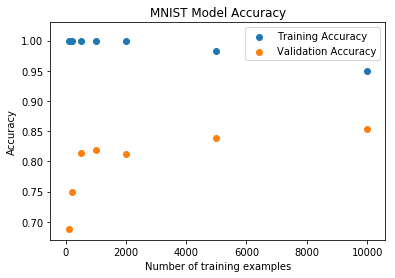

In [12]:
plt.scatter(mnist_model["Size"], mnist_model["Training Accuracy"])
plt.scatter(mnist_model["Size"], mnist_model["Validation Accuracy"])

plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")

plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("MNIST Model Accuracy")


plt.show();

Our accuracies are in the desired [70%, 90%] range.

## (b)
Use a Sklearn's `LinearSVC` model to create a SVM that classifies our email data. Train the model and then store it's training and validation accuracies, in a `Pandas` Dataframe, for the different sizes of training samples.

In [9]:
# Function trains linear SVC model and predicts labels
# Returns error rates from training and validation sets
def spam_svm(size):
    model = svm.LinearSVC()
    model.fit(spam_new_train[:size], spam_new_label[:size])
    
    predicted_train = model.predict(spam_new_train[:size])
    predicted_validation = model.predict(spam_validation_train)
    
    return accuracy_score(spam_new_label[:size], predicted_train), accuracy_score(spam_validation_label, predicted_validation)

# Create a Pandas DF object to enable easy plotting
spam_model = pd.DataFrame(columns=["Size", "Training Accuracy", "Validation Accuracy"])

for size in [100, 200, 500, 1000, 2000, len(spam_new_train)]:
    train_acc, validation_acc = spam_svm(size)
    spam_model = spam_model.append({"Size": size, "Training Accuracy": train_acc\
                                    , "Validation Accuracy": validation_acc}, ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
spam_model

,Size,Training Accuracy,Validation Accuracy
0,100.0,0.880000,0.762089
1,200.0,0.865000,0.770793
2,500.0,0.804000,0.777563
3,1000.0,0.803000,0.777563
4,2000.0,0.806000,0.783366
5,4138.0,0.815611,0.787234


Plot our Spam model's accuracies vs. different numbers of training samples.

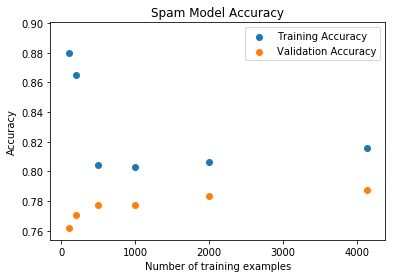

In [11]:
plt.scatter(spam_model["Size"], spam_model["Training Accuracy"])
plt.scatter(spam_model["Size"], spam_model["Validation Accuracy"])

plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")

plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Spam Model Accuracy")


plt.show();

Our accuracies are in the desired [70%, 90%] range.

## (c)
Use a Sklearn's `SVC` model, for performance reasons cited on Piazza, to create a SVM that classifies our pixel data. Train the model and then store it's training and validation accuracies, in a `Pandas` Dataframe, for the different sizes of training samples.

In [13]:
# Function trains linear SVC model and predicts labels
# Returns error rates from training and validation sets
def cifar_svm(size):
    model = svm.SVC(kernel="linear")
    model.fit(cifar_new_train[:size], cifar_new_label[:size])

    predicted_train = model.predict(cifar_new_train[:size])
    predicted_validation = model.predict(cifar_validation_train)

    return accuracy_score(cifar_new_label[:size], predicted_train), accuracy_score(cifar_validation_label,
                                                                                           predicted_validation)


# Create a Pandas DF object to enable easy plotting
cifar_model = pd.DataFrame(columns=["Size", "Training Accuracy", "Validation Accuracy"])

for size in [100, 200, 500, 1000, 2000, 5000]:
    train_acc, validation_acc = cifar_svm(size)
    cifar_model = cifar_model.append({"Size": size, "Training Accuracy": train_acc\
                                      , "Validation Accuracy": validation_acc},
                                     ignore_index=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [14]:
cifar_model

,Size,Training Accuracy,Validation Accuracy
0,100.0,1.0,0.2468
1,200.0,1.0,0.2642
2,500.0,1.0,0.2890
3,1000.0,1.0,0.2998
4,2000.0,1.0,0.3092
5,5000.0,1.0,0.3154


For our Cifar model, plot its accuracies vs. the different number of training samples.

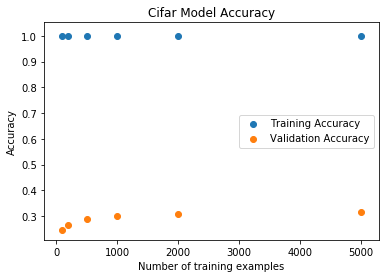

In [15]:
plt.scatter(cifar_model["Size"], cifar_model["Training Accuracy"])
plt.scatter(cifar_model["Size"], cifar_model["Validation Accuracy"])

plt.xlabel("Number of training examples")
plt.ylabel("Accuracy")

plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.title("Cifar Model Accuracy")

plt.show();

Our accuracies are in the desired [25%, 35%] range.

# 4) Hyperparameter Tuning

## (a)

Looking for $c \in [10^{-10}, 10^{10}]$ (a geometric range that will be computationally cheaper than the naive approach) that minimizes Validation Error ==> highest accuracy on validation dataset. Iterate through powers of 10 to find the best c-value.

In [16]:
def mnist_svm_c(c, size=10000):
    model = svm.LinearSVC(C=c)
    model.fit(mnist_new_train[:size], mnist_new_label[:size])
    
    predicted_train = model.predict(mnist_new_train[:size])
    predicted_validation = model.predict(mnist_validation_train)
    
    return accuracy_score(mnist_new_label[:size], predicted_train), accuracy_score(mnist_validation_label, predicted_validation)

# Create a Pandas DF object to enable easy plotting
mnist_model_c = pd.DataFrame(columns=["C-value", "Training Accuracy", "Validation Accuracy"])

power = -10
c = 10 ** power

for i in range(20):
    train_acc, validation_acc = mnist_svm_c(c)
    mnist_model_c = mnist_model_c.append({"C-value": c, "Training Accuracy": train_acc\
                                          , "Validation Accuracy": validation_acc}, ignore_index=True)
    
    #if c == 10 ** -10:
    #    power += 1
    #    pass        
    #elif mnist_model_c["Validation Error"][i] < mnist_model_c["Validation Error"][i - 1]:
    #    power += 1
    #else:
    #    break
    
    power+=1
    c = 10 ** power

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
mnist_model_c

,C-value,Training Accuracy,Validation Accuracy
0,1.000000e-10,0.7591,0.7533
1,1.000000e-09,0.8321,0.8319
2,1.000000e-08,0.8862,0.8813
3,1.000000e-07,0.9164,0.8987
4,1.000000e-06,0.9362,0.8989
5,1.000000e-05,0.9565,0.8876
6,1.000000e-04,0.9632,0.8684
7,1.000000e-03,0.9445,0.8466
8,1.000000e-02,0.9293,0.8349
9,1.000000e-01,0.9261,0.8389


Plot our model's vlidation accuracy vs. the different c-values.

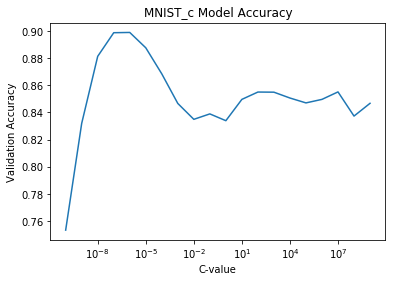

In [18]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_xscale("log")

plt.xlabel("C-value")
plt.ylabel("Validation Accuracy")

plt.title("MNIST_c Model Accuracy")

ax.plot(mnist_model_c["C-value"], mnist_model_c["Validation Accuracy"])


plt.show();

In [29]:
best_acc = max(mnist_model_c["Validation Accuracy"])
best_c = mnist_model_c[mnist_model_c["Validation Accuracy"] == best_acc]["C-value"]
best_c

4    0.000001
Name: C-value, dtype: float64

Our best c-value, the one that achieves the highest accuracy, is approximately $10^{-6}$ .

# 5) K-Fold Cross-Validation

## (a)
Split the spam data with random indices based on a given seed value in the range(5). This ensures the 5-fold cross validation partitions the data stochastically while keeping the correct rows and labels together at the same indices.

In [19]:
def k_split_spam(train, label, seed_val):
    spam_idx = np.arange(len(spam_train))
    np.random.seed(seed_val)
    np.random.shuffle(spam_idx)

    return train[spam_idx], label[spam_idx]

validation_features,  validation_labels = {}, {}
train_features, train_labels = {}, {}
proportion = int(len(spam_train) * (1 / 5))

for i in range(5):
    spam_train, spam_label = k_split_spam(spam_train, spam_label, i)
    spam_validation_train, spam_validation_label = spam_train[:proportion], spam_label[:proportion]
    spam_new_train, spam_new_label = spam_train[proportion:], spam_label[proportion:]
    
    validation_features[i], validation_labels[i] = spam_train[:proportion], spam_label[:proportion]
    train_features[i], train_labels[i] = spam_train[proportion:], spam_label[proportion:]

Use a Sklearn's `LinearSVC` model to create a SVM that classifies our spam data. Train the model and then store its training and validation accuracies, in a `Pandas` Dataframe, with c-value=1; a c-value that seemed to yield the best accuracy empirically when I was testing.

In [20]:
def spam_cross_validation(c=1, k=5):    
    size = int(len(spam_train) / k)
    train_accuracies = []
    validation_accuracies = []
    
    for i in range(k):
        model = svm.LinearSVC(C=c)
        model.fit(train_features[i][:size], train_labels[i][:size])

        predicted_train = model.predict(train_features[i][:size])
        predicted_validation = model.predict(validation_features[i])
        
        train_accuracies.append(accuracy_score(train_labels[i][:size], predicted_train))
        validation_accuracies.append(accuracy_score(validation_labels[i], predicted_validation))
        
    return np.average(train_accuracies), np.average(validation_accuracies)

# Create a Pandas DF object to enable easy plotting
spam_model_cross = pd.DataFrame(columns=["C-value", "Avg. Training Accuracy", "Avg. Validation Accuracy"])

In [21]:
power = -10
c = 10 ** power

for i in range(20):
    train_acc, validation_acc = spam_cross_validation(c)
    spam_model_cross = spam_model_cross.append({"C-value": c, "Avg. Training Accuracy": train_acc\
                                          , "Avg. Validation Accuracy": validation_acc}, ignore_index=True)
    
    #if c == 10 ** -10:
    #    power += 1
    #    pass        
    #elif spam_model_cross["Avg. Validation Error"][i] < spam_model_cross["Avg. Validation Error"][i - 1]:
    #    power += 1
    #else:
    #    break
    
    power+=1
    c = 10 ** power

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
spam_model_cross

,C-value,Avg. Training Accuracy,Avg. Validation Accuracy
0,1.000000e-10,0.754932,0.751838
1,1.000000e-09,0.755126,0.751838
2,1.000000e-08,0.755126,0.751838
3,1.000000e-07,0.755126,0.751838
4,1.000000e-06,0.755706,0.753578
5,1.000000e-05,0.762476,0.757253
6,1.000000e-04,0.768472,0.761896
7,1.000000e-03,0.778337,0.765957
8,1.000000e-02,0.797485,0.782979
9,1.000000e-01,0.813733,0.801161


Plot our cross-validated spam model's avg. validation accuracies vs. the different c-values we could have used.

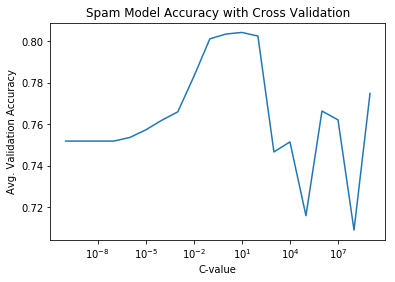

In [23]:
figure = plt.figure()
ax = figure.add_subplot(1, 1, 1)
ax.set_xscale("log")

plt.xlabel("C-value")
plt.ylabel("Avg. Validation Accuracy")

plt.title("Spam Model Accuracy with Cross Validation")

ax.plot(spam_model_cross["C-value"], spam_model_cross["Avg. Validation Accuracy"])


plt.show();

In [32]:
best_val_acc = max(spam_model_cross["Avg. Validation Accuracy"])
best_val_c = spam_model_cross[spam_model_cross["Avg. Validation Accuracy"] == best_val_acc]["C-value"]
best_val_c

11    10.0
Name: C-value, dtype: float64

Our best c-value--the one that minimizes our model's validation error--is then approximately $10^1=10$